# Energy scenario design in Aalborg

Created by [Michele Urbani](mailto:murbani@fbk.eu) on February 7th, 2025.

The research presented in {cite:p}`MAHBUB2016140` is replicated here to
show how the MOEA package works.

MOEA is based on the [PyMOO](https://pymoo.org/) package for the implementation
of the multi-objective evolutionary algorithms (MOEA) and on EnergyPLAN
for the energy scenario modeling.

PyMOO breaks down multi-objective optimization into the following steps.

1. **Model description**: the optimization models must be encoded in a PyMOO
``Problem`` class, or one of its subclasses, e.g., ``ElementwiseProblem``, etc.

    1. The ``Problem`` class required to declare a set of high level problem
    information, such as the number of variables, objective, inequality
    constraints, and equality constraints.
    2. The objective function evaluation procedure, which in our case calls
    EnergyPLAN to resolve the instances defined by the solutions found by the
    algorithm. The output values are then read, and eventually postprocessed,
    and provided to the algorithm together with constraint violations.

2. **Algorithm declaration**: in this case the standard NSGA-II is used.
3. **Resolution**: the utility function ``minimize`` is used to optimize the
problem.

## Problem declaration

The words problem and model are use interchangeably here.
In the following, the Aalborg model is explained in details to show an example
of problem declarations.
To avoid declaring the model twice, the class is declared in
``moea.models.aalborg.AalborgA`` and the code is print here with further
comments.

In [1]:
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from pymoo.optimize import minimize
from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import Hypervolume

from moea.models import get_model
from moea.algorithms import get_algorithm


2025-05-05 16:52:59.940 | INFO     | moea.config:<module>:11 - PROJ_ROOT path is: C:\Users\murbani\moea


In [2]:
model_name = 'Aalborg'
model = get_model(model_name)

The following cell shows the code used for initializing the model.

The only parameter that can be provided is ``data_file``, i.e., the path to the
default EnergyPLAN input data. The default value for this variable is already
set to ensure reproducibility of the research.

Input variables are defined as a pandas DataFrame: each row corresponds to a
variable, whose index is the variable name in EnergyPLAN, and the columns
``lb`` and ``ub`` correspond to the lower and upper bound of the variable,
respectively.

Later, the parent class is initialized with ``super().__init__()``. This method
requires problem infomation, such as the number of variables, the number of
(in)equality constraints, the number of objectives, and the upper and lower
bounds.
Decision variable are assumed to be real numbers.

Even though it is not visible in the code below, the class inherits from the
``moea.models.base_model.BaseModel`` class.

In [3]:
# Print models class __init__ code
init_code = inspect.getsource(model.__init__)
display(Markdown("```python\n" + init_code + "```"))

```python
    def __init__(self,
                 data_file: Union[str, Path] = \
                    "Aalborg_2050_Plan_A_44ForOptimization_2objectives.txt",
                 **kwargs):
        """
        Parameters:
        -----------
        - ``data_file``: str or Path

            The path to the input file. This file is used as a template to
            generate the input files for each individual.
            The values will be replaced by the values of the decision variables
            when generating the input files.
        """

        # Define the input variables.
        self.vars = pd.DataFrame.from_dict({
            'input_cap_chp3_el': \
                {'lb':0, 'ub': 1000, "dk0": True, "dk1": False},
            'input_cap_hp3_el': \
                {'lb':0, 'ub': 1000, "dk0": True, "dk1": False},
            'input_cap_pp_el': \
                {'lb': 0, 'ub': 1000, "dk0": None, "dk1": None},
            'input_RES1_capacity': \
                {'lb': 0, 'ub': 1500, "dk0": True, "dk1": False},
            'input_RES2_capacity': \
                {'lb': 0, 'ub': 1500, "dk0": True, "dk1": False},
            'input_RES3_capacity': \
                {'lb': 0, 'ub': 1500, "dk0": True, "dk1": False},
            'input_cap_boiler3_th': \
                {'lb': 0, 'ub': 250, "dk0": None, "dk1": None},
        }, dtype=float, orient='index')

        # Initialize the parent class
        super().__init__(
            n_var=len(self.vars),
            n_ieq_constr=3,
            n_obj=2,
            xl=self.vars['lb'].values,
            xu=self.vars['ub'].values,
            data_file=data_file,
            **kwargs
        )
```

The evalutation method is the core of the objective function calculation.

The ``Aalborg`` model calls EnergyPLAN twice per iterations.
During each iteration, the first call to EnergyPLAN sets only the

- `input_cap_chp3_el`,
- `input_cap_hp3_el`,
- `input_RES1_capacity`,
- `input_RES2_capacity`,
- `input_RES3_capacity`,

variables as input.
Then, the annual maximum *Boiler 3 Heat* and *PP Electr.* are read from
EnergyPLAN results, and they are used to set the value of
`input_cap_pp_el` and `input_cap_boiler3_th`.
Finally, if solutions met certain conditions, EnergyPLAN is called again
with the new variable values, and CO2 emissions and cost are used as the
objective function values.

The ``_evaluate`` method does not return a value but it expects you to set a
value for, at the least, the ``out["F"]`` value of the ``out`` dictionary.
This must be a numpy array, whos size is $N_{solutions} \times N_{objectives}$.

The dictionary values ``"G"`` and ``"H"`` can be used to declare the left-hand
side of inequalities and equalities constraints, respectively.
These arrays must have size $N_{solutoins} \times N_{constraints}$.

In [4]:
eval_code = inspect.getsource(model._evaluate)
display(Markdown("```python\n" + eval_code + "```"))

```python
    def _evaluate(self, x, out, *args, **kwargs):
        # Dump the full list of variables to a file
        for i, ind in enumerate(x):
            dump_input({k: ind[j] for j, k in enumerate(self.vars.index)},
                        i, self.default_data)

        # Call EnergyPLAN using spool mode; only the input files are needed
        execute_energyplan_spool([f"input{i}.txt" for i in range(len(x))])

        # Parse the output file
        Y = find_values(
            ENERGYPLAN_RESULTS,
            "CO2-emission (corrected)",
            "TOTAL ANNUAL COSTS",
            ("Annual Maximum", "Import Electr."),
            ("Annual", "Balance3 Heat"),
            ("Annual Minimum", "Stabil. Load"),
        )

        # The CO2 emissions are set directly from the results files, whereas
        # the cost is adjusted by the reduction in investment and fixed O&M
        # for the cases where CHP > PP.
        out["F"] = Y[:, :2]

        # CONSTRAINTS
        # Since there are a fes constraints, we evaluate the left-hand side
        # of the constraints and store the values in out["G"].

        # Transmission line capacity of export/import: 160 MW. This constraint
        # enforces the system to produce enough electricity so that it does not
        # require to import more than 160 MW.
        import_constr = np.array(Y[:, 2]) - 160

        # Heat balance. This constraint enforces the system to produce exactly
        # the amount of heat necessary to meet the heat demand.
        heat = - np.array(Y[:, 3])

        # Grid stabilization: More than 30% of power production in all hours
        # must come from units able to supply grid support (see [77] for
        # details on grid stability in EnergyPLAN).
        # This constraint is already taken into account by EnergyPLAN so we
        # just need to subtract the value from 100 to have a constraint that
        # is satisfied when the value is positive.
        stable_load = 100 - np.array(Y[:, 4])

        out["G"] = np.column_stack([
            import_constr,
            stable_load,
            heat,
        ])
```

## Problem resolution

The utility function ``minimize`` is the default way to run an algorithm on a
problem of your choice.
It requires to pass the model variable, i.e., the variable to which the model
has been assigned, the algorithm, and a stopping criterion.
Optionally, a ``seed`` value can be provided, which enables replicability of
results, and ``verbose`` can be set to ``True`` to visualize runtime infomrmation.

The ``minimize`` function returns an objects storing results. Below, we show
how to extract some quantities of interest and plot them.

### NSGA-2 Algorithm

The NSGA-2 algorithm {cite:p}`DEB2002` is one of the most popular algorithm
for multi-objective optimization and it is used here for benchmarking of
results against the Domain Knowledge algorithm proposed by {cite:t}`MAHBUB2016483`.

In [5]:
model_name = 'Aalborg'
model = get_model(model_name)

algorithm_name = 'NSGA2'
# The population size can be provided when the algorithm is declared
# using the `pop_size` argument. If it is not explicitly set, the
# default value is 100.
algorithm = get_algorithm(algorithm_name)

res = minimize(
    model,
    algorithm,
    ('n_gen', 100),  # The stopping criterion is set to 100 generations
    seed=2903,       # Setting a seed allows us to replicate an experiment
    verbose=True     # Print information while the algorithm is running
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     17 |  0.000000E+00 |  0.3897000000 |             - |             -
     2 |      200 |     21 |  0.000000E+00 |  0.000000E+00 |  0.1536050157 |         nadir
     3 |      300 |     31 |  0.000000E+00 |  0.000000E+00 |  0.0323679727 |         ideal
     4 |      400 |     35 |  0.000000E+00 |  0.000000E+00 |  0.0041322314 |         ideal
     5 |      500 |     42 |  0.000000E+00 |  0.000000E+00 |  0.0371835443 |         ideal
     6 |      600 |     49 |  0.000000E+00 |  0.000000E+00 |  0.0328997705 |         ideal
     7 |      700 |     48 |  0.000000E+00 |  0.000000E+00 |  0.0045696877 |         nadir
     8 |      800 |     60 |  0.000000E+00 |  0.000000E+00 |  0.0301051868 |         ideal
     9 |      900 |     70 |  0.000000E+00 |  0.000000E+00 |  0.0043891734 |         ideal
    10 |     1000 |     77 |  0.000000E+00 |  0.000000E+00 |  0.0165467626 |         ideal

#### Results analysis

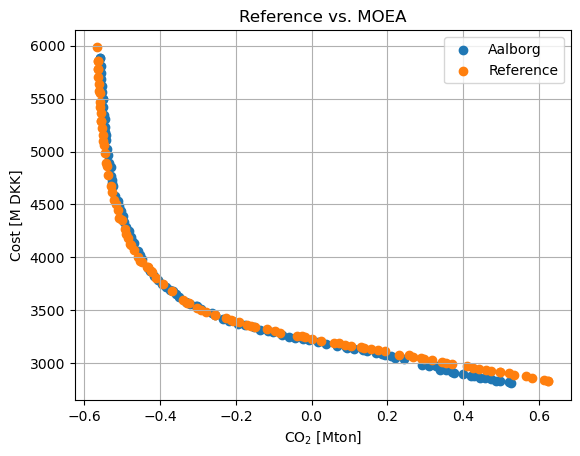

In [6]:
# Get the pareto-front
F = res.F

# Load reference data from the paper, no index column and space separated
ref = pd.read_csv('aalborg-reference.csv', sep=' ', header=None,
                  names=['CO2 [Mton]', 'Cost [M DKK]'],
                  index_col=False)

# Plot the pareto-front
plt.scatter(F[:,0], F[:,1], label=model_name)
plt.scatter(ref.values[:,0], ref.values[:,1], label='Reference')
plt.xlabel('CO$_2$ [Mton]')
plt.ylabel('Cost [M DKK]')
plt.title('Reference vs. MOEA')
plt.grid()
plt.legend()

plt.show()

#### Convergence analysis

The results of the paper {cite:t}`MAHBUB2016140` are used as reference to
measure the quality of the solution. We implement the Inverted Generational
Distance (IGD) {cite:t}`COELLOCOELLO2004688` to quantify the distance from any
point in the set of solutions $Z$ to the closest point in the set of
reference solutions $A$.

$$
IGD(A) = \frac{1}{|Z|} \left( \sum_{i=1}^{|Z|} \hat{d}_i ^{\,p} \right) ^{1/p}
$$

where $\hat{d}_i$ represents the Euclidean distance ($p=2$) from $z_i$ to its
nearest reference point in $A$.

The lower the value of the IGD, the closer the set $A$ to the reference set
$Z$.

In [7]:
igds = {}

ind = IGD(ref.values)
igds[(model_name, algorithm_name)] = ind(res.F)
print("IGD", ind(res.F))

IGD 10.813519515695852


## Domain knowledge algorithm

In {cite:ps}`MAHBUB2016483`, the Domain Knowledge algotithm is proposed to exploit experts' knowledge of the underlying energy scenario to enhance the MOEA.
In the following, the `Aalborg` model is run using the Domain Knowledge algorithm to check for improvements.

In [2]:
model_name = 'Aalborg'
algorithm_name = 'mahbub2016'

model = get_model(model_name)
algorithm = get_algorithm(algorithm_name, pop_size=100)

res = minimize(
    model,
    algorithm,
    ('n_gen', 100),
    seed=4395,
    verbose=True,
    save_history=True
)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      101 |     22 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      201 |     31 |  0.000000E+00 |  0.000000E+00 |  0.0378668441 |             f
     3 |      301 |     46 |  0.000000E+00 |  0.000000E+00 |  0.0032537961 |         nadir
     4 |      401 |     58 |  0.000000E+00 |  0.000000E+00 |  0.0033272837 |         ideal
     5 |      501 |     62 |  0.000000E+00 |  0.000000E+00 |  0.0146181384 |         ideal
     6 |      601 |     84 |  0.000000E+00 |  0.000000E+00 |  0.0088704908 |         nadir
     7 |      701 |     94 |  0.000000E+00 |  0.000000E+00 |  0.1070376432 |         nadir
     8 |      801 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0097244733 |         ideal
     9 |      901 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0025910996 |             f
    10 |     1001 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0018110238 |             f

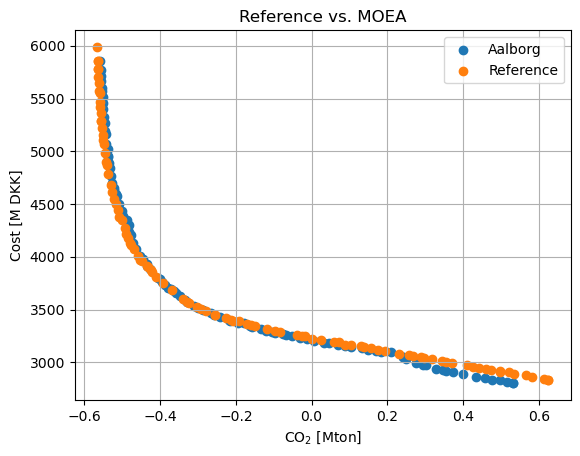

In [3]:

# Get the pareto-front
F = res.F

# Load reference data from the paper, no index column and space separated
ref = pd.read_csv('aalborg-reference.csv', sep=' ', header=None,
                  names=['CO2 [Mton]', 'Cost [M DKK]'],
                  index_col=False)

# Plot the pareto-front
plt.scatter(F[:,0], F[:,1], label=model_name)
plt.scatter(ref.values[:,0], ref.values[:,1], label='Reference')
plt.xlabel('CO$_2$ [Mton]')
plt.ylabel('Cost [M DKK]')
plt.title('Reference vs. MOEA')
plt.grid()
plt.legend()

plt.show()

Since the Pareto front from the paper is available, we use is to calculate the
inverted generational distance (IGD) {cite:ps}`COELLO2024` to the front
obtained by the domain knowledge algorithm.

In [4]:
ind = IGD(ref.values)
print("IGD", ind(res.F))

IGD 10.564689698409463


To furhter show that the algorithm converged to a stable front, the hyper-
volume (HV) measure {cite:ps}`FONSECA2006` is used.
HV values are normalized to be independent of problem values and focus on the
convergence of results.
It is worth mentioning that convergence is tested to the stability of HV values
with the number of generations, and it should asymptotically tend to a value.
It does not matter that this value is lower than one.

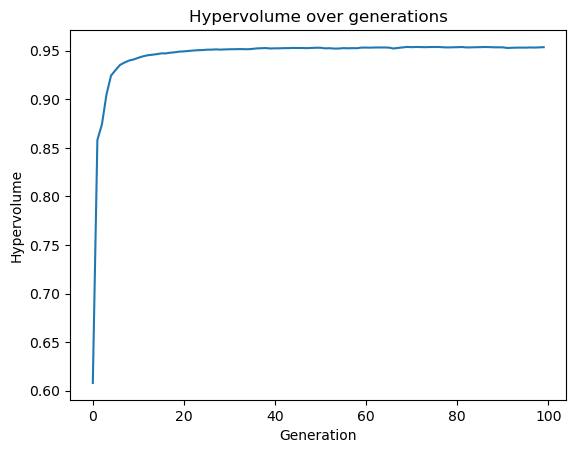

In [5]:
# Calculate the reference point
ref_point = np.max(np.vstack([i.pop.get("F") for i in res.history]), axis=0)
# Extract the fronts from the history
fronts = [i.opt.get("F") for i in res.history]
# Normalize the fronts
normalized_fronts = [i / ref_point for i in fronts]
# Initialize the hypervolume indicator with the reference point (1, 1)
hv = Hypervolume(np.array([1, 1]))
# Calculate the hypervolume for each front
hv_vals = [hv(f) for f in normalized_fronts]

# Plot the hypervolume over generations
plt.plot(hv_vals)
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.title("Hypervolume over generations")
plt.show()

## References

```{bibliography}
:style: unsrt
```